# Challenge based Learning:

## TASK
Count the number of trees in Campus Golm. Estimate the area that is covered by trees on campus. How many trees (in %) are deciduous?

## Members
- Emmanuel Olguin	
- Raphael Kluge 		
- Nikolas Bertrand	


## STEP 1 import modules and load the Data

In [160]:
# Import libraries
import laspy
from whitebox import WhiteboxTools
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
from scipy.spatial import cKDTree
from scipy import stats
from mpl_toolkits.mplot3d import Axes3D
import pdal
import json

import rpy2.robjects as robjects
from rpy2.robjects import pandas2ri
#load_ext rpy2.ipython # first time only
%reload_ext rpy2.ipython



Above we also loaded rpy2, with that we can run R in side .ipynb 

In [350]:
%%R

library(lidR)
library(raster)
library(sp)
library(ForestTools)
library(gridExtra)
library(ggplotify)
library(rgdal)
library(sf)

Linking to GEOS 3.11.1, GDAL 3.6.4, PROJ 9.1.1; sf_use_s2() is TRUE

Attaching package: ‘sf’

The following object is masked from ‘package:lidR’:

    st_concave_hull



# STEP 2 LOAD THE DATA 
Next we load the data and get some stats on it as in how many points are there per return and how many are there in total. 

In [354]:
#Load Data 
las = laspy.read("/home/nibe/PROJECTS/golm_tree_analysis/data/Golm_May06_2018_Milan_UTM33N_WGS84_6digit_cl.las")

SyntaxError: invalid syntax (3354931877.py, line 6)

# STEP 3 Apply a filter to reduce the number of points: 

First we need to filter out some of the returns. 
Since we know vegetation is mostly in the 3,4,5 return we have removed the 6 and 2 return. 

In [376]:

filtered_points = las.points[(las.classification != 6) & (las.classification != 2) & (las.classification != 1) & (las.classification != 4)]
# Now you can calculate z-scores and filter these 'Z' values as before

len(filtered_points)


2432736

After have the :filtered points we apply those to a new las and save it. 

In [377]:
new_las = laspy.LasData(las.header)
new_las.points = filtered_points.copy()
new_las.write('../data/no_buildings_filtered_data.las')

In [371]:
file_path = "/home/nibe/PROJECTS/golm_tree_analysis/data/no_buildings_filtered_data.las"
#output_path = "/home/nibe/PROJECTS/golm_tree_analysis/data/filteres.las"

x1 = 362179.9
x2 = 362208.9
y1 = 5808782.12
y2 = 5808660.72
lasX = laspy.read(file_path)
# Create a new LAS object with the same header as the original LAS file
new_lasX = laspy.LasData(lasX.header)

#indices = np.where(
#    (las.x >= x1) & (las.x <= x2) & (las.y >= y1) & (las.y <= y2)
#)[0]

#new_las.points = las.points[np.logical_not(np.isin(np.arange(len(las.points)), indices))]
# Get the indices of the points falling inside the square
indices = np.where((lasX.x >= x1) & (lasX.x <= x2) & (lasX.y >= y1) & (lasX.y <= y2))[0]

# Copy all points except the ones falling inside the square to the new LasData object
new_lasX.points = lasX.points[np.logical_not(np.isin(np.arange(len(lasX.points)), indices))]
# Close the LAS files
new_lasX.write('../data/filtered_dataX.las')

This results in the following point cloud if looked at throuch cloud compare viewer. 

Buildings are mostly gonne, some are still left, including their outside walls. But Overall it did a good job in showing vegetation especially the trees, earlier we also filtered out the road and most of the ground.

![No Buildings Filtered data ](../data/no_building2.png)

# STEP 4 Segment the trees, create CHMs and identify the trees. 

In the next section we switch to R, we Read the lidar file again.

In [378]:
%%R
library(lidR)
las <- readLAS("/home/nibe/PROJECTS/golm_tree_analysis/data/no_buildings_filtered_data.las", select = "xyzr")

In [379]:
%%R
library(sp)

# Next we let the segment Trees algorithm that is included the lidr package run over the .las


In [380]:
%%R
las <- segment_trees(las, li2012(dt1 = 1.5, dt2 = 2, R = 2, Zu = 15, hmin = 2, speed_up = 2))

# Next Create CHM

In the first step we will use the Point to raster algorithm with multiple resolutions from 0.5 to 3. After that we will run a smoothing algorithm over it. 
Finally we will create a pitfree CHM using the pitfree algorithm. 

In [381]:
%%R
# Point-to-raster 2 resolutions
chm_p2r_05 <- rasterize_canopy(las, 0.5, p2r(subcircle = 0.2), pkg = "terra")
chm_p2r_1 <- rasterize_canopy(las, 1, p2r(subcircle = 0.2), pkg = "terra")
chm_p2r_2 <- rasterize_canopy(las, 2, p2r(subcircle = 0.2), pkg = "terra")
chm_p2r_3 <- rasterize_canopy(las, 3, p2r(subcircle = 0.2), pkg = "terra")

In [382]:
%%R
# Post-processing median filter
kernel <- matrix(1, 3, 3)
chm_p2r_05_smoothed <- terra::focal(chm_p2r_05, w = kernel, fun = median, na.rm = TRUE)
chm_p2r_1_smoothed <- terra::focal(chm_p2r_1, w = kernel, fun = median, na.rm = TRUE)
chm_p2r_2_smoothed <- terra::focal(chm_p2r_2, w = kernel, fun = median, na.rm = TRUE)
chm_p2r_3_smoothed <- terra::focal(chm_p2r_3, w = kernel, fun = median, na.rm = TRUE)

In [383]:
%%R
chm_pitfree_05_1 <- rasterize_canopy(las, 1, pitfree(), pkg = "terra")
chm_pitfree_05_2 <- rasterize_canopy(las, 2, pitfree(subcircle = 0.2), pkg = "terra")
chm_pitfree_05_3 <- rasterize_canopy(las, 3, pitfree(), pkg = "terra")
chm_pitfree_05_3s <- rasterize_canopy(las, 3, pitfree(subcircle = 0.2), pkg = "terra")

# NEXT we create a variable function for the window size.
This means for example that based on that for example everything with a height of 3 or below has a window size of 2 


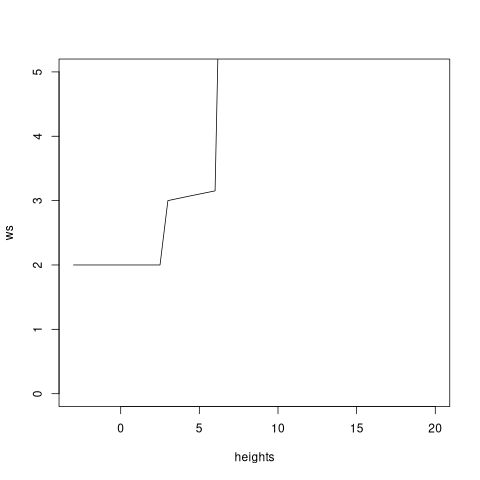

In [384]:
%%R
f <- function(x) {
  y <- 2.6 * (-(exp(-0.02*(x-3)) - 1)) + 3
  y[x < 3] <- 2
  y[x > 6] <- 9
  return(y)
}

heights <- seq(-3,20,0.5)
ws <- f(heights)
plot(heights, ws, type = "l",  ylim = c(0,5))

# Next we a different function for the window size

the results are vastly different to the above  especially the pitfree algorithm, as seen below the results are not just double they are 24 times as much. 

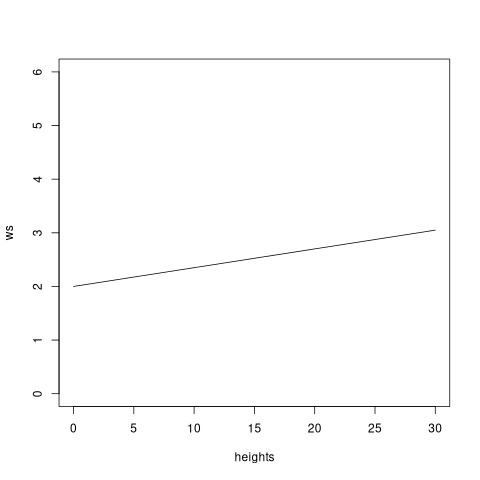

In [87]:
%%R 
f <- function(x) {x * 0.035 + 2}
heights <- seq(0,30,5)
ws <- f(heights)
plot(heights, ws, type = "l", ylim = c(0,6))



# Another window size function.
the function below also give different types of results. more unrealistic than the first function and comparable to the second. 

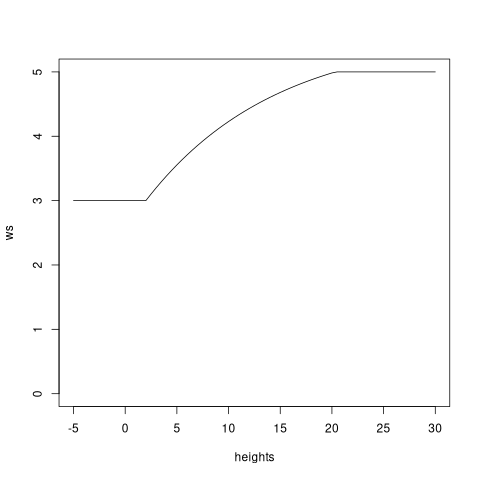

In [89]:
%%R 
f <- function(x) {
  y <- 2.6 * (-(exp(-0.08*(x-2)) - 1)) + 3
  y[x < 2] <- 3
  y[x > 20] <- 5
  return(y)
}
heights <- seq(-5,30,0.5)
ws <- f(heights)
plot(heights, ws, type = "l",  ylim = c(0,5))


In [386]:
%%R 
# ALL DEPENDED ON THE ABOVE WINDOW SIZE
ttops_chm_p2r_05 <- locate_trees(chm_p2r_05, lmf(f))
ttops_chm_p2r_1 <- locate_trees(chm_p2r_1, lmf(f))
ttops_chm_p2r_2 <- locate_trees(chm_p2r_2, lmf(f))
ttops_chm_p2r_3 <- locate_trees(chm_p2r_3, lmf(f))
# P2R SMOOTHED
ttops_chm_p2r_05_smoothed <- locate_trees(chm_p2r_05_smoothed, lmf(f))
ttops_chm_p2r_1_smoothed <- locate_trees(chm_p2r_1_smoothed, lmf(f))
ttops_chm_p2r_2_smoothed <- locate_trees(chm_p2r_05_smoothed, lmf(f))
ttops_chm_p2r_3_smoothed <- locate_trees(chm_p2r_1_smoothed, lmf(f))
# PITFREE
ttops_chm_pitfree_05_1 <- locate_trees(chm_pitfree_05_1, lmf(f))
ttops_chm_pitfree_05_2 <- locate_trees(chm_pitfree_05_2, lmf(f))
ttops_chm_pitfree_05_3 <- locate_trees(chm_pitfree_05_3, lmf(f))
ttops_chm_pitfree_05_3s <- locate_trees(chm_pitfree_05_3s, lmf(f))

print("p2r")
print(nrow(ttops_chm_p2r_05))
print(nrow(ttops_chm_p2r_1))
print(nrow(ttops_chm_p2r_2))
print(nrow(ttops_chm_p2r_3))
p2r <- nrow(ttops_chm_p2r_05)
p2r <- nrow(ttops_chm_p2r_1)
p2r <- nrow(ttops_chm_p2r_2)
p2r <- nrow(ttops_chm_p2r_3)
average <- mean(p2r)
print("The average P2R")
print(unlist(average))

print(" p2r smoothed")
print(nrow(ttops_chm_p2r_05_smoothed))
print(nrow(ttops_chm_p2r_1_smoothed))
print(nrow(ttops_chm_p2r_2_smoothed))
print(nrow(ttops_chm_p2r_3_smoothed))
p2rs <- nrow(ttops_chm_p2r_05_smoothed)
p2rs <- nrow(ttops_chm_p2r_1_smoothed)
p2rs <- nrow(ttops_chm_p2r_2_smoothed)
p2rs <- nrow(ttops_chm_p2r_3_smoothed)
average2 <- mean(p2rs)
print("The average P2R- SMOOTHED")
print(unlist(average2))

print("pitfree")
print(nrow(ttops_chm_pitfree_05_1))
print(nrow(ttops_chm_pitfree_05_2))
print(nrow(ttops_chm_pitfree_05_3))
print(nrow(ttops_chm_pitfree_05_3s))
pf <- nrow(ttops_chm_pitfree_05_1)
pf <- nrow(ttops_chm_pitfree_05_2)
pf <- nrow(ttops_chm_pitfree_05_3)
pf <- nrow(ttops_chm_pitfree_05_3s)
averagepf <- mean(pf)
print("The average PITFREE")
print(unlist(averagepf))

[1] "p2r"
[1] 1131
[1] 1078
[1] 945
[1] 1008
[1] "The average P2R"
[1] 1008
[1] " p2r smoothed"
[1] 1082
[1] 1025
[1] 1082
[1] 1025
[1] "The average P2R- SMOOTHED"
[1] 1025
[1] "pitfree"
[1] 715
[1] 606
[1] 601
[1] 547
[1] "The average PITFREE"
[1] 547


# PLOTTING THE RESULTS 

next we have included Plots of the different algorithm for in are perspective the best result. 

[1] "tree count"
[1] 1078


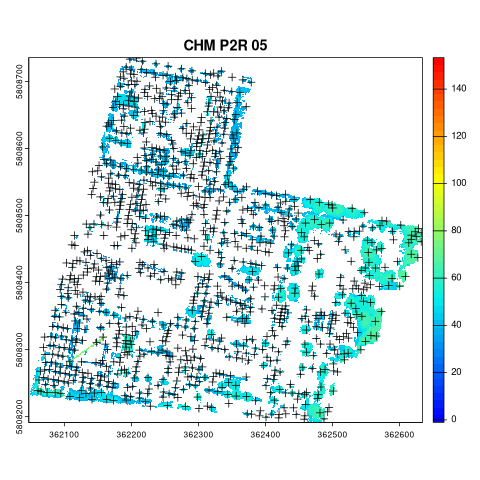

In [390]:
%%R
plot(chm_p2r_05, main = "CHM P2R 05", col = col); plot(sf::st_geometry(ttops_chm_p2r_05), add = T, pch = 3)
print("tree count")
print(nrow(ttops_chm_p2r_1))


In [388]:
%%R 
library(grid)
library(gridExtra)

[1] "tree count"
[1] 1078


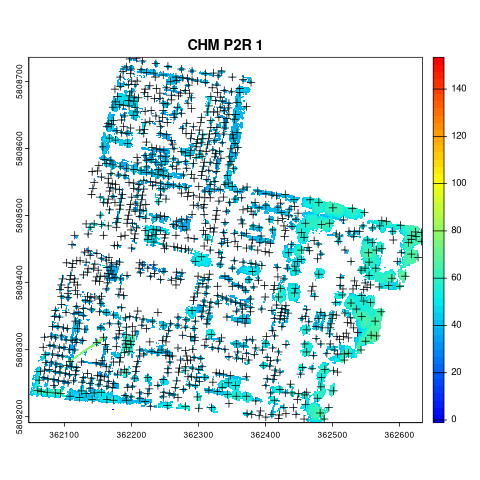

In [389]:
%%R
plot(chm_p2r_1, main = "CHM P2R 1", col = col); plot(sf::st_geometry(ttops_chm_p2r_1), add = T, pch = 3)
print("tree count")
print(nrow(ttops_chm_p2r_1))


[1] "tree count"
[1] 945


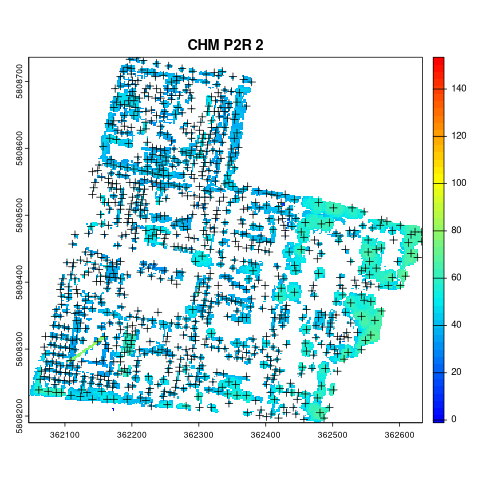

In [391]:
%%R
plot(chm_p2r_2, main = "CHM P2R 2", col= col ); plot(sf::st_geometry(ttops_chm_p2r_2), add = T, pch =3)
print("tree count")
print(nrow(ttops_chm_p2r_2))

[1] "tree count"
[1] 1008


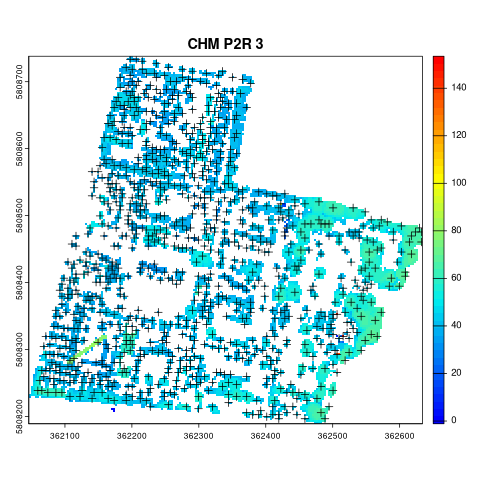

In [392]:
%%R
plot(chm_p2r_3, main = "CHM P2R 3", col= col ); plot(sf::st_geometry(ttops_chm_p2r_3), add = T, pch =3)
print("tree count")
print(nrow(ttops_chm_p2r_3))

[1] "tree count"
[1] 1082


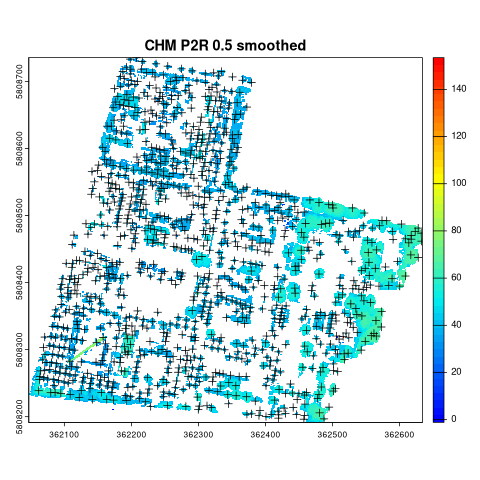

In [393]:
%%R 
plot(chm_p2r_05_smoothed, main = "CHM P2R 0.5 smoothed", col = col); plot(sf::st_geometry(ttops_chm_p2r_05_smoothed), add = T, pch =3)
print("tree count")
print(nrow(ttops_chm_p2r_05_smoothed))

[1] "tree count"
[1] 1025


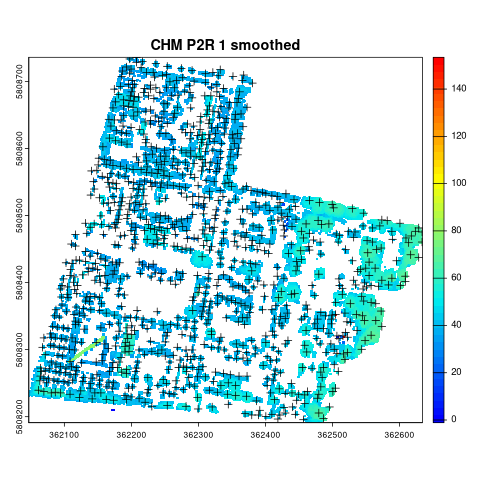

In [394]:
%%R
plot(chm_p2r_1_smoothed, main = "CHM P2R 1 smoothed", col = col); plot(sf::st_geometry(ttops_chm_p2r_1_smoothed), add = T, pch =3)
print("tree count")
print(nrow(ttops_chm_p2r_1_smoothed))

[1] 1082


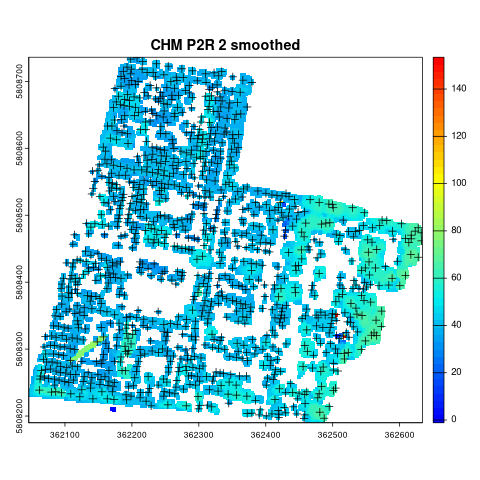

In [395]:
%%R 
plot(chm_p2r_2_smoothed, main = "CHM P2R 2 smoothed", col = col); plot(sf::st_geometry(ttops_chm_p2r_2_smoothed), add = T, pch =3)
print(nrow(ttops_chm_p2r_2_smoothed))


# PITFREE ALGORITHM

[1] "tree count"
[1] 715


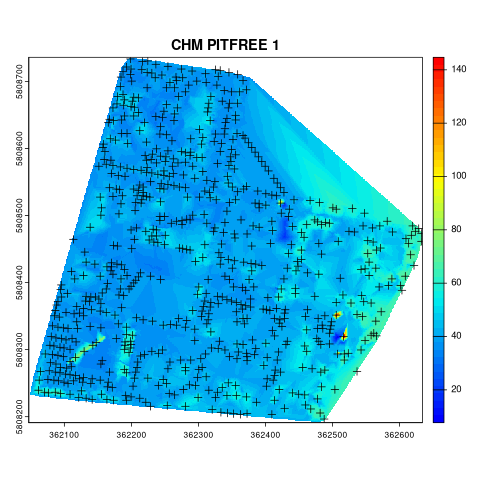

In [396]:
%%R
plot(chm_pitfree_05_1, main = "CHM PITFREE 1", col = col); plot(sf::st_geometry(ttops_chm_pitfree_05_1), add = T, pch =3)
print("tree count")
print(nrow(ttops_chm_pitfree_05_1))



[1] "tree count"
[1] 606


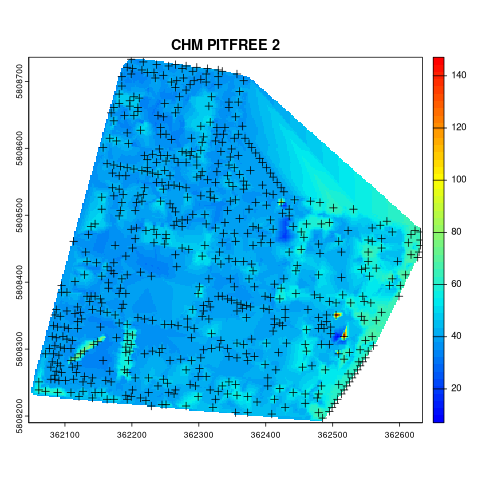

In [397]:
%%R
plot(chm_pitfree_05_2, main = "CHM PITFREE 2", col = col); plot(sf::st_geometry(ttops_chm_pitfree_05_2), add = T, pch =3)
print("tree count")
print(nrow(ttops_chm_pitfree_05_2))

[1] "tree count"
[1] 601


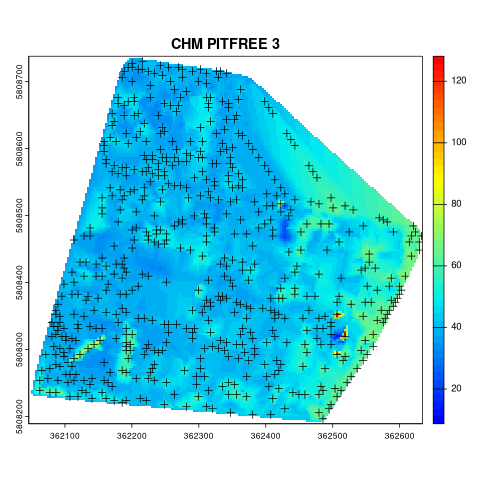

In [398]:
%%R
plot(chm_pitfree_05_3, main = "CHM PITFREE 3", col = col); plot(sf::st_geometry(ttops_chm_pitfree_05_3), add = T, pch =3)
print("tree count")
print(nrow(ttops_chm_pitfree_05_3))

[1] "tree count"
[1] 547


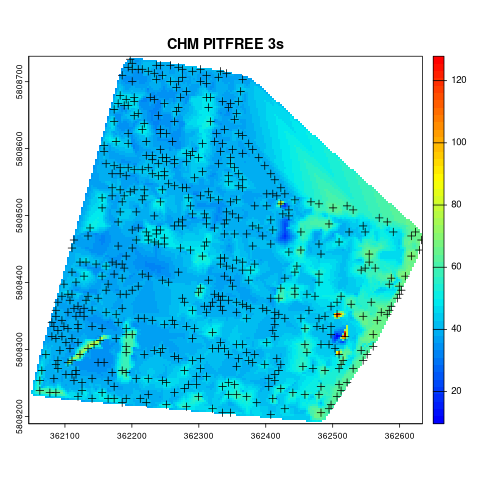

In [399]:
%%R
plot(chm_pitfree_05_3s, main = "CHM PITFREE 3s", col = col); plot(sf::st_geometry(ttops_chm_pitfree_05_3s), add = T, pch =3)
print("tree count")
print(nrow(ttops_chm_pitfree_05_3s))

# NEXT STEP - TREE CROWNS
earlier calculated ttops and foresttools crowns are different aspects of tree analysis in the ForestTools package. The ttops are the treetops detected from a CHM, and the foresttools crowns are the tree crowns outlined from these treetops.

since crown function needs spatRaster we have to reload the las file 

uses the same window size function as above!

for foresttools crown support the vwf algorithm has to be used

[1] 545


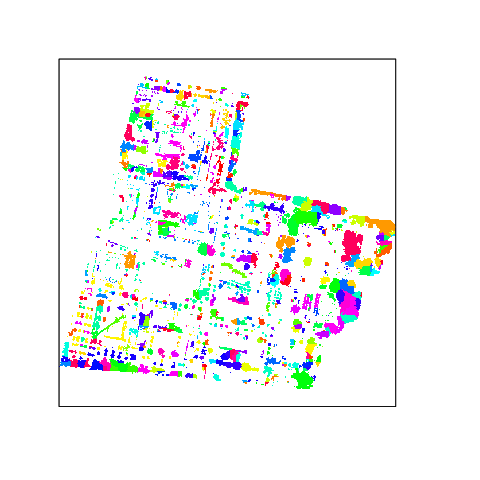

In [400]:
%%R 
chm <- rasterize_canopy(las, 1, p2r(0.2), pkg = "raster")
#f <- function(x) {x * 0.02 + 0.3}

ttops <- vwf(CHM = chm, winFun = f, minHeight = 2)

plot(chm, xlab = "", ylab = "", xaxt = 'n', yaxt = 'n')
plot(ttops, col = "green", pch = 20, cex = 0.5, add = TRUE)

# Create crown map
crowns <- mcws(treetops = ttops, CHM = chm,  minHeight = 3, verbose = FALSE)

# Plot crowns
plot(crowns, col = sample(rainbow(50), length(unique(crowns[])), replace = TRUE), legend = FALSE, xlab = "", ylab = "", xaxt='n', yaxt = 'n')
print(nrow(crowns))



In [401]:
%%R
crowns_poly <- mcws(treetops = ttops, CHM = chm, minHeight = 3, verbose = FALSE, format="polygons")
summary <- sp_summarise(crowns_poly, variables = c("crownArea", "height"))
print(summary)
# Calculate total crown area
total_crown_area <- sum(crowns_poly$crownArea)

# Print total crown area
print(paste("Total Crown Area :", total_crown_area))

                     Value
TreeCount        815.00000
crownAreaMean     60.16933
crownAreaMedian   20.00000
crownAreaSD      107.87199
crownAreaMin       1.00000
crownAreaMax    1346.00000
heightMean        47.39092
heightMedian      44.72000
heightSD          10.65566
heightMin         18.38000
heightMax        153.45000
[1] "Total Crown Area : 49038"


In [402]:
%%R 
# Read the LAS file
las2 <- readLAS("/home/nibe/PROJECTS/golm_tree_analysis/data/Golm_May06_2018_Milan_UTM33N_WGS84_6digit_cl.las")
# Specify the resolution of the raster data
resolution <- 1
# Create a grid using the grid_metrics function
# Here we use the length function as our metric, which will return 1 for all grid cells that contain at least one point.
metrics <- grid_metrics(las2, ~length(X), resolution)

# Calculate the total area covered by the .las file
# Total area is computed by summing up non-NA grid cells and multiplying by the cell's area
total_area <- sum(!is.na(values(metrics))) * resolution * resolution
print(paste0("Total Area :", total_area))

[1] "Total Area :192458"


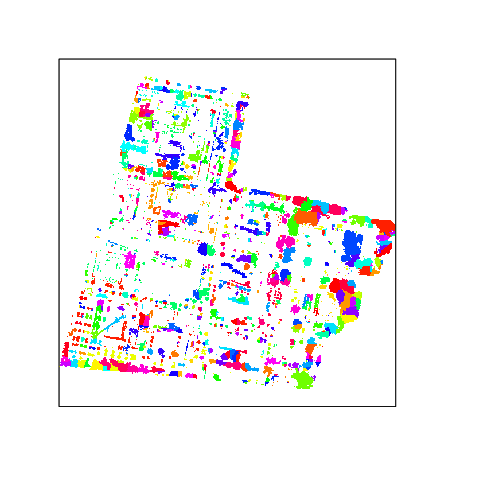

In [403]:
%%R
crown_values <- getValues(crowns)
unique_crowns <- unique(crown_values)
plot(crowns, col = sample(rainbow(50), length(unique_crowns), replace = TRUE), legend = FALSE, xlab = "", ylab = "", xaxt='n', yaxt = 'n')

In [404]:
%%R
# compare total Crown Area with total area
print(paste0("Proportion of area covered by tree crowns : ", (total_crown_area/total_area)*100, "__%"))

[1] "Proportion of area covered by tree crowns : 25.4798449531846__%"
